In [1]:
import os
import re
import json
import nltk
import pickle
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import config
from text_helpers import init_collection, add_col_values, \
    add_wordcloud_string, disp_wordcloud

In [2]:
# Download and import "book"
nltk.download('book', quiet=True)
from nltk import book

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [3]:
# read in character DataFrame
df = pd.read_csv(config.PATH_RES + 'df_chars.csv')
df.head()

,Name,Gender,Race,Faction,Status
0,A'dal,Unknown,Naaru,Neutral,Alive
1,Aedelas Blackmoore,Male,Human,Neutral,Deceased
2,Aegwynn,Female,Human,Neutral,Deceased
3,Aessina,Female,Wisp,Neutral,Unknown
4,Aethas Sunreaver,Male,Blood Elf,Horde,Alive


# NLTK on Cleaned Wikipages

In [4]:
# create NLTK text of cleaned texts
file_list = [fn for fn in glob(config.PATH_CLEAN + '*.txt')]
text_corpus = nltk.corpus.PlaintextCorpusReader('', file_list)
wiki_text = nltk.Text(text_corpus.words())

# create NLTK text of words
file_list = [fn for fn in glob(config.PATH_WORDS + '*.txt')]
words_corpus = nltk.corpus.PlaintextCorpusReader('', file_list)
wiki_words = nltk.Text(words_corpus.words())

## Community Stuff

## Word Clouds

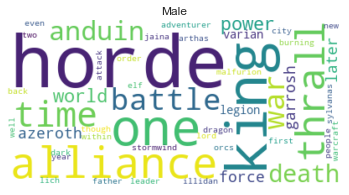

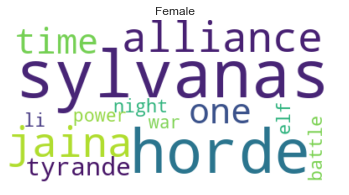

In [5]:
# generate wordclouds for Gender split
with open(config.PATH_RES + 'Gender_dict.json', 'rb') as f:
    col = pickle.load(f)
col = add_wordcloud_string(col)

for split in ['Male', 'Female']:
    filename = config.PATH_PLOTS + f'wc_{split}.png'
    disp_wordcloud(split, col, savepath=filename, maskpath=f'./data/{split}.jpg')

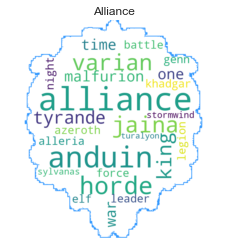

In [6]:
# generate wordclouds for Faction split
with open(config.PATH_RES + 'Faction_dict.json', 'rb') as f:
    col = pickle.load(f)
col = add_wordcloud_string(col)

# alliance
for split in ['Alliance', 'Horde']:
    filename = config.PATH_PLOTS + f'wc_{split}.png'
    disp_wordcloud(split, col, savepath=filename, maskpath=f'./data/{split}.jpg', contour_color=config.COLOR_ALLIANCE)

# Horde
# split = 'Horde'
# filename = config.PATH_PLOTS + f'wc_{split}.png'
# disp_wordcloud(split, col, savepath=filename, maskpath='./data/mask_horde.jpg', contour_color=config.COLOR_HORDE)


## leftovers

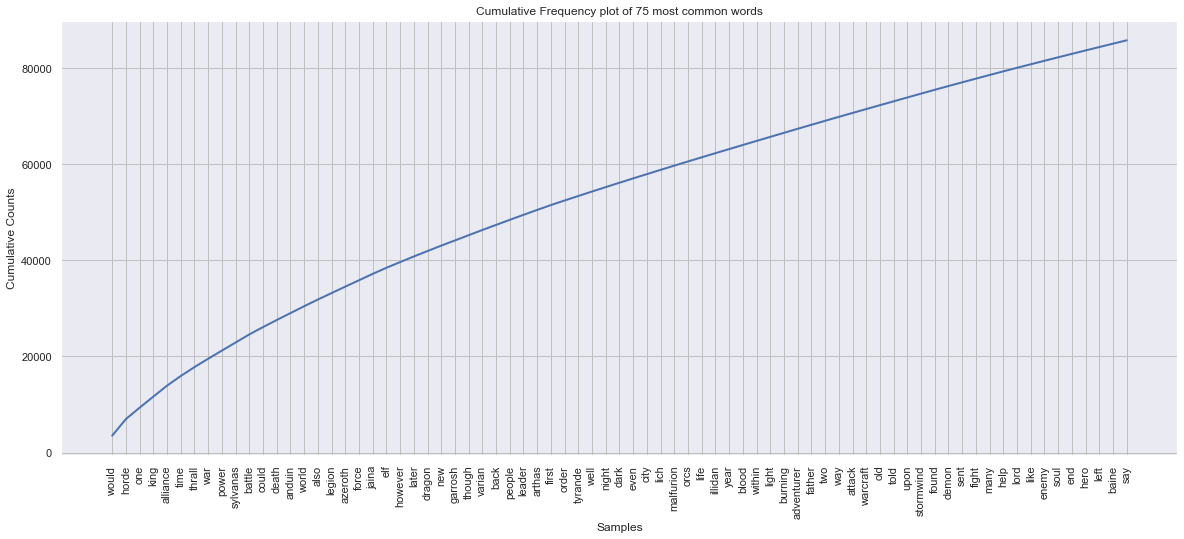

In [7]:
# Get the frequency distribution of the text
fd = book.FreqDist(wiki_words)

# Display the 75 most common tokens in a cumulative frequency plot
plt.figure(figsize=(20, 8))
plt.title('Cumulative Frequency plot of 75 most common words')
fd.plot(75, cumulative=True)
plt.show()

# NLTK on WoWhead User Comments

# Test shit